# Final Project 
K-Nearest Neighbors for Regression<br>
https://catalog.data.gov/dataset/electric-vehicle-title-and-registration-activity

In [1]:
import pandas as pd
import numpy as np

#Read the csv file
cars_df = pd.read_csv("car.csv")

#Data cleaning: Remove unwanted columns
cars_df = cars_df.iloc[:,[0,1,3,4,5,6,7,8,10,11,16]]

#Data cleaning: Remove all rows with no sale price
#Why not predict the price and not drop the row? 
#Because rows with no sale price are not guarenteed to have odometer reading
#Additionaly, the dataset is big enough to be able to afford dropping rows
cars_df = cars_df[cars_df["Sale Price"] != 0]

#Data cleaning: Remove all cars that are not Battery Electric Vehicle (Example: Hybrid cars)
cars_df = cars_df[cars_df["Clean Alternative Fuel Vehicle Type"] == "Battery Electric Vehicle (BEV)"]

#Data cleaning: Getting rid of outliers
cars_df = cars_df[cars_df["Odometer Reading"] >= 0]
cars_df = cars_df[cars_df["Odometer Reading"] <= 250000]
cars_df = cars_df[cars_df["Model Year"] >= 2000]
cars_df = cars_df[cars_df["Model Year"] <= 2023]
cars_df = cars_df[cars_df["Sale Price"] <= 300000]
cars_df = cars_df[cars_df["Sale Price"] > 100]

#Since we know each car has a unique vin number, we
#can simplify the vin numbers and use them as index
cars_df["VIN (1-10)"] = cars_df.reset_index().index + 1
cars_df = cars_df.rename(columns={"VIN (1-10)": "Car ID"})

# Split the data into training and test sets.
cars_df = cars_df.set_index("Car ID")
cars_train = cars_df.loc[:100000].copy()
cars_test = cars_df.loc[100000:].copy()

# Smaller sample data set which has chosen random rows (every 10th row)
cars_temp = cars_df.iloc[::100, :]
cars_temp = cars_temp.iloc[:,[1,2,3,6,7,8,9]]

# Log transform the target(Sale Price) for visualization purposes only
cars_train["log(Sale Price)"] = np.log(cars_train["Sale Price"])

cars_df
#cars_train
#cars_test
#cars_temp

,Clean Alternative Fuel Vehicle Type,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,New or Used Vehicle,Sale Price,Transaction Year
Car ID,,,,,,,,,,
1,Battery Electric Vehicle (BEV),2014,MERCEDES-BENZ,B-Class,Passenger,87,37031,Used,19443,2018
2,Battery Electric Vehicle (BEV),2018,TESLA,Model 3,Passenger,215,50,New,65700,2018
3,Battery Electric Vehicle (BEV),2023,TESLA,Model Y,Passenger,0,15,New,84440,2022
4,Battery Electric Vehicle (BEV),2014,TESLA,Model S,Passenger,208,30840,Used,66864,2017
5,Battery Electric Vehicle (BEV),2022,TESLA,Model Y,Passenger,0,15,New,61440,2022
...,...,...,...,...,...,...,...,...,...,...
109424,Battery Electric Vehicle (BEV),2022,RIVIAN,R1T,Truck,0,100,New,82295,2022
109425,Battery Electric Vehicle (BEV),2022,TESLA,Model 3,Passenger,0,187,New,75290,2022
109426,Battery Electric Vehicle (BEV),2011,NISSAN,Leaf,Passenger,73,64000,Used,1540,2022


Let's focus on just two features for now: winter rainfall (**win**) and average summer temperature (**summer**). Let's plot the training data, using a color gradient to represent the target (**log(price)**). Notice how we can customize the color gradient using the `cmap=` argument. A list of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).

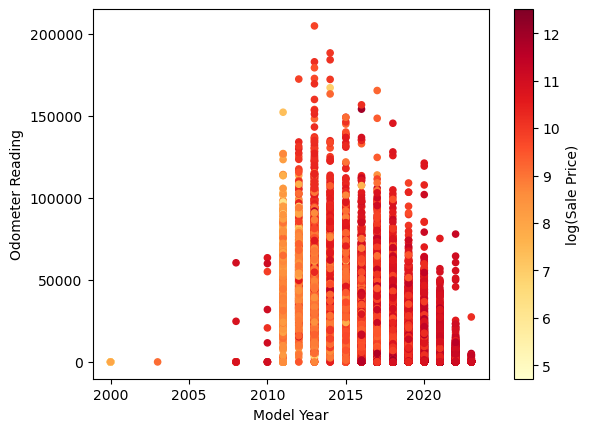

In [2]:
import matplotlib.cm as cm

ax = cars_train.plot.scatter(x="Model Year", y="Odometer Reading", c="log(Sale Price)", cmap=cm.YlOrRd)

Notice how cars that are newer and have low mileage on this scatterplot are more expensive. Similarly, older cars and cars with more mileage are cheaper. This insight is the basis of the $k$-nearest neighbors algorithm for predicting the car price. <br>

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features.
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

Let's implement this in code. First, we extract the training data and scale the features:

In [3]:
X_train = cars_train[["Model Year", "Odometer Reading"]]
y_train = cars_train["log(Sale Price)"]

#To decide: Which is better? Standardizing or Normalizing? I think normalize

# Standardize the features
#X_train_mean = X_train.mean()
#X_train_sd = X_train.std()
#X_train_st = (X_train - X_train_mean) / X_train_sd

# Normalize the features
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_nr = (X_train - X_train_min) / (X_train_max - X_train_min)

Now, we get the features for the new observation (i.e., the last row which is 2021 with 13 miles), standardizing/normalizing it in the same way.

In [4]:
x_new = cars_test.loc[109496, ["Model Year", "Odometer Reading"]]

#x_new_st = (x_new - X_train_mean) / X_train_sd
#x_new_st

x_new_nr = (x_new - X_train_min) / (X_train_max - X_train_min)
x_new_nr

KeyError: 109496

Now we calculate the (Euclidean) distances between the 2021 car with 13 miles and the cars in the training data.

In [ ]:
dists = np.sqrt(((X_train_nr - x_new_nr) ** 2).sum(axis=1))
dists

Now, we sort the distances. The first 5 of these are the nearest neighbors. To get the year of these nearest neighbors, we get the index.

In [11]:
i_nearest = dists.sort_values().index[:300]
i_nearest

NameError: name 'dists' is not defined

We can look up these years in the training data.

In [12]:
cars_train.loc[i_nearest]

NameError: name 'i_nearest' is not defined

To make a prediction for the price of the 2021 car with 13 miles, we average the sale prices of these 5-nearest neighbors.

In [13]:
y_train.loc[i_nearest].mean()
np.exp(y_train.loc[i_nearest].mean())

NameError: name 'i_nearest' is not defined

So the model predicts that the price of the 1986 is about 10.8, which is about $49,064.

Of course, the model above only had two features so it was easy to visualize the "nearest neighbors" on the scatterplot. The magic of $k$-nearest neighbors is that it still works when there are more features and the data is not possible to visualize.

## K-Nearest Neighbors in scikit-learn

Now let's see how to implement $k$-nearest neighbors in scikit-learn. Recall from the previous lesson that all scikit-learn models follow the three-step pattern:

1. Declare the model.
2. Fit the model to training data.
3. Use the model to predict on test data.

To fit a $k$-nearest neighbors model instead of a linear regression model, we only need to modify the first step. Instead of declaring a model of type `LinearRegression`, we define a model of type `KNeighborsRegressor`, specifying the value of $k$ as one of the parameters. Because `KNeighborsRegressor` works with distances, it is a good idea to scale the features before passing the features into the model. (Refer back to Chapter 3 for a full explanation.)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = MinMaxScaler()
X_train_nr = scaler.fit_transform(X_train)
X_new_nr = scaler.transform(pd.DataFrame([x_new])) # needs to be a DataFrame
y_train = cars_train["log(Sale Price)"]

model = KNeighborsRegressor(n_neighbors=300)
model.fit(X=X_train_nr, y=y_train)
model.predict(X=X_new_nr)

np.exp(model.predict(X=X_new_nr)) 

NameError: name 'x_new' is not defined

This is the same predicted value that we got by implementing $k$-nearest neighbors manually.

In the code above, we had to be careful to standardize the training data and the test data in exactly the same way before fitting the $k$-nearest neighbors model. Most machine learning models have many more preprocessing steps. As the preprocessing gets more complex, it is easy to accidentally omit one of the preprocessing steps. For this reason, scikit-learn provides a _Pipeline_ object, which simply chains together a sequence of preprocessing and model building steps. If we call `Pipeline.fit()` or `Pipeline.predict()` on the data, all of the steps will be applied to the data in a consistent manner.

In [10]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
          MinMaxScaler(),
          KNeighborsRegressor(n_neighbors=300)
)

pipeline.fit(X=X_train, y=y_train)
pipeline.predict(X=pd.DataFrame([x_new]))
np.exp(pipeline.predict(X=pd.DataFrame([x_new]))) 

array([48777.11149596])

## The K-Nearest Neighbors Regression Function

A predictive model is simply a function $f$ that maps feature values ${\bf x}$ to target values $y$. We can visualize $f$ when ${\bf x}$ consists of just a single feature, such as **age**. In the previous lesson, we saw that $f$ is just a line when the model is linear regression. What does $f$ look like when the model is a $k$-nearest neighbors regressor?

First, we extract the training data. There is no need to scale the features in this case because there is only one feature. (The point of scaling is to bring all of the variables to the same scale.

In [16]:
X_train = cars_train[["Odometer Reading"]]
y_train = cars_train["Sale Price"]

Now we fit the $k$-nearest neighbor model as before. We do not need to standardize the feature in this case because there is only one feature. Standardizing is only useful when there are multiple features that we want to bring to the same scale.

In [17]:
# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X=X_train, y=y_train)

KNeighborsRegressor(n_neighbors=6)

In order to graph $f$, we need to evaluate the predictive model at a grid of feature values. Since age ranges from 12 to 40 in the training data, we create a grid of ${\bf x}$ values from 10 to 45, make predictions at these values, and plot these predictions as a curve.

<AxesSubplot:xlabel='Odometer Reading', ylabel='Sale Price'>

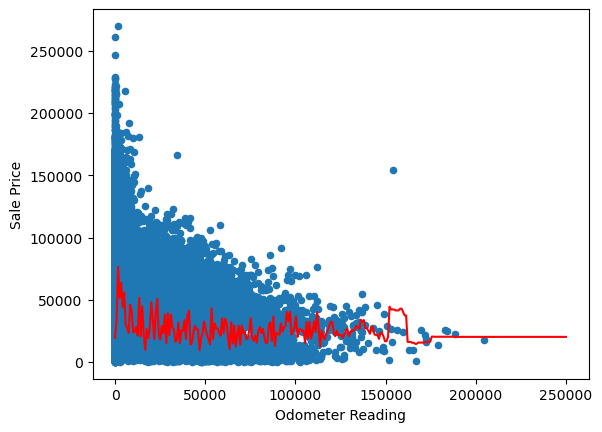

In [19]:
# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["Odometer Reading"] = np.linspace(0, 250000, num=300)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["Odometer Reading"]
)

# Plot the predictions.
cars_train.plot.scatter(x="Odometer Reading", y="Sale Price")
y_new_.plot.line(c='r')

Unlike the linear regression model, the $k$-nearest neighbor model is piecewise constant. For example, wines more than 37 years old all have the same 5-nearest neighbors, so the prediction is constant in that range.